# K-Nearest Neighbors Algorithm and Its Application

## Introduction

As we have learnt, NaiveBayes and decision tree are all eager learning algorithm which constructs a classification model before receiving new data to do queries. In contrast, lazy learning algorithm stores all training data until a query is made. K-nearest neighbors (a.k.a k-NN) algorithm is one of the most famous lazy learning algorithms, as well as among the simplest of all machine learning algorithms.

The idea of k-NN algorithm is quite simple. Whenever we have a new point to classify, we find its K nearest neighbors from the training data. Let's say we have two class of data labeled separately as green square and red circle. The new data which is a blue triangle is waiting for classification. Right now we don't know class the triangle belongs to and our goal is to find a proper family for it.

![](http://i.imgur.com/n1OK9h2.png)

Usually, the easiest way for us to decide whether a person is good or bad is through searching his or her friends. Here, we should study all the friends of the blue triangle. However, how we define friendship for data? We know that each data is actually a spot in space and it has a distance to all other data spots. In k-NN algorithm, k decides the friendly distance. Given the classification criteria above, if k = 3 (solid line circle), the blue triangle is assigned to the class of red circles because there are 2 red circles and only 1 green square inside the inner circle; if k = 5 (dashed line circle), the blue triangle is assigned to the class of green square because there are 3 green squares but 2 red circles inside the outer circle. This seems a statistical way to help us find the right class for new data. **We assign a class label only considering the number of friends near by and their classes.**

The distance here can be calculated using one of the following measures:
- Euclidean Distance
- Minkowski Distance
- Mahalanobis Distance

## Weighted K-NN Algorithm

As we discussed in last session, we begin with a naive k-NN algorithm which only take the number of appearance of data in each class into consideration. We may get a wrong classification result in a situation like below:

![](http://i.imgur.com/exy2MUY.png)

Within a proper distance, there are more green squares than red circles. However, the blue triangle is closely surrounded by red circles and all green squares locate farther from it. The blue triangle is most likely to be one of the class of red circles even though there are more green squares show up in the friendly circle.

> One way to overcome this problem is to weight the classification, taking into account the distance from the test point to each of its k nearest neighbors.

There are several approaches to apply weight to the class of each of the k nearest points. Here I introduce one approach called **attribute/feature weighted k-NN**.

There are two assumptions:
- All the attribute values are numerical or real
- Class attribute values are discrete integer values

Detailed steps:

- Read the training data
- Set K to some value
- Calculate Euclidean distances to all training data points
- Find the K nearest neighbors based on the distances
- Assign weight to each feature
- Return the class that represents the maximum of the k instances
- Calculate the accuracy

## Other Improvements

### Density based k-NN

In Density based K-NN the distance between test and training instances is increased in sparse area and reduced in dense areas because it not only considers the density of test instance but also the densities of its K neighbors.

### Variable k-NN

It has been observed that the values in K nearest neighbor classification results heavily depends upon the number of neighbors and each data has different K value that is suitable for it. This approach finds the optimum K value for each classification and generate an array which contains the best K value for each training set instances.

### Class based k-NN

Sometimes the size of each class can also cause problem. When one class have too many instances
while others have too few instances, the class with smallest size won't be selected by our algorithm. We should take this factor into consideration as well.

## Application

In this tutorial, we are going to apply k-NN algorithm on sentences from the abstract and introduction of 30 scientific articles. Firstly, we call KNeighborsClassifier from sklearn library, train it with training data set and calculate prediction accuracy on testing data. Then we implement our own K-NN algorithm. We will compare the accuracy of our algorithm with the one of sklearn library. Finally, we implement an improved k-NN algorithm based on naive k-NN.

### Data Set

[Sentence Classification Data Set from UCI](http://archive.ics.uci.edu/ml/datasets/Sentence+Classification#)

### Training Data Format

A snippet of training data may like:
> MISC    although the internet as level topology has been extensively studied over the past few years  little is known about the details of the as taxonomy

> MISC    an as  node  can represent a wide variety of organizations  e g   large isp  or small private business  university  with vastly different network characteristics  externs

> AIMX    in this paper  we introduce a radically new approach based on machine learning techniques to map all the ases in the internet into a natural as taxonomy

> OWNX    we successfully classify  NUMBER   NUMBER  percent  of ases with expected accuracy of  NUMBER   NUMBER  percent

The first attribute is a label of:
1. AIM: "A specific research goal of the current paper"
2. OWNX: "(Neutral) description of own work presented in current paper"
3. CONT: "Statements of comparison with or contrast to other work; weaknesses of other work"
4. BASIS: "Statements of agreement with other work or continuation of other work"
5. MISC: "(Neutral) description of other researchers' work"
The second part is a sentence in the paper.

Our goal here is to use K-NN to guess the category of a given sentense.

Here are libraries we need:

In [6]:
import numpy as np
import pandas as pd
from nltk import word_tokenize
from sklearn.neighbors import KNeighborsClassifier
from collections import Counter
import matplotlib
matplotlib.use('svg')
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

### Feature Scoring
We are provided with an extra key words list for each category. We can use those words to score the likelihood of a senctence's category. For example, sentences contain words like "we", "introduce" and "design" are more likely to describe the research goal of the current paper, which should belongs to category AIM. If a sentence contain `N` words in AIM word list, we give it's AIM feature score `N`.

In [7]:
# Read in key words for each category
def build_word_set(filename):
    with open(filename) as f:
        lines = f.readlines()
        return {word.strip() for word in lines if word}

aim_set = build_word_set("./word_lists/aim.txt")
base_set = build_word_set("./word_lists/base.txt")
own_set = build_word_set("./word_lists/own.txt")
constract_set = build_word_set("./word_lists/contrast.txt")
stopwords_set = build_word_set("./word_lists/stopwords.txt")

Train data on classifier. Return feature matrix and label vector. If `train` is `false`, the output label vector will be empty.

In [8]:
def load_data(filename, train=True):
    """
    Training data format like:
    
    'AIMX In this paper we derive the equations for Loop Corrected Belief Propagation on a continuous variable Gaussian model'
    
    For each single line of raw data, caculate the feature score of it and put it into feature matrix (and label matrix if it's training data) 
    """
    feature_m = np.empty((0,4), dtype=int)
    label_m = np.empty((0,1))
    def caculate_score(line):
        aim_score, base_score, own_score, cons_score = 0, 0, 0, 0
        word_list = [w for w in word_tokenize(line.lower()) if w not in stopwords_set]
        for word in word_list:
            if word in aim_set:
                aim_score += 1
            if word in base_set:
                base_score += 1
            if word in own_set:
                own_score += 1
            if word in constract_set:
                cons_score += 1
        return aim_score, base_score, own_score, cons_score
        
    with open(filename) as f:
        for line in f:
            if line.startswith("###"):
                continue
            else:
                if train:
                    label, sentence = line.split(' ', 1)
                    a, b, o, c = caculate_score(sentence)
                    feature_m = np.append(feature_m, np.array([[a, b, o, c]]), axis=0)
                    label_m = np.append(label_m, np.array([[label]]), axis=0)
                else:
                    a, b, o, c = caculate_score(line)
                    feature_m = np.append(feature_m, np.array([[a, b, o, c]]), axis=0)

    return feature_m, label_m

Let's try out one training data and see the accuracy of our classifier!

In [9]:
f, l = load_data('./arxiv_annotate10_7_3.txt')    
sklearn_knn = KNeighborsClassifier(n_neighbors=3)
sklearn_knn.fit(f, l.ravel())

correct = 0.0
for i in range(len(f)):
    if sklearn_knn.predict(f[i].reshape(1,-1)) == l[i]:
        correct += 1
print correct/len(f)

0.716417910448


## Performance Analysis

In this part, we are going to evaluate the performance of our algorithm in contrast to the sklearn library.

There are several perspectives for us to analysis an algorithm, time complexity, space complexity, error rate, etc.
Basic kNN algorithm stores all samples, so the space complexity depends on the volume of samples. The total time complexity is `O(nk+nd)` with n examples each of dimension d, including time to compute distance to all samples and find k closest examples. Here, let's take a deep look at how k influence the error rate.

### How to Choose k?

In theory, if infinite number of samples available, the larger is k, the better is classification. The lower bound of k is 1. In this case, the k-nn model may be too sensitive to “noise”. The upper bound is n, the number of samples. If k is that big, then we will take all samples into consideration. This means that the class of the testing data only depends on the majority of the class of all the samples and it's nothing to do with distance.

The program we implemented below is for generating error rates with different k. We choose k from 1 to 50. Then draw a figure to show the relationship between k and accuracy rate.

## Visualized Result

### Load Data

Firstly, we load data for use. `data.txt` is a much bigger data set which runs much slower.

In [15]:
f, l = load_data('./data.txt')

### Test Sklearn Library

On one hand, we test sklearn library with different k.

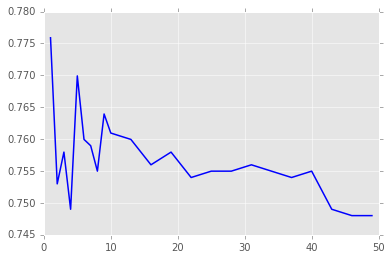

In [16]:
x_points = [x for x in range(1,10)] + [x for x in range(10, 50, 3)]
y_points = []

for k in x_points:
    correct = 0.0
    sklearn_knn = KNeighborsClassifier(n_neighbors=k)
    sklearn_knn.fit(f, l.ravel())
    for i in range(len(f)):
        if sklearn_knn.predict(f[i].reshape(1,-1)) == l[i]:
            correct += 1
    y_points.append(correct/len(f))
    
plt.plot(x_points, y_points, 'b-',lw=1.5)

### Test Our K-NN

On the other hand, we implement our own simplest K-NN algorithm first and test its accuracy rate.

In [20]:
class KNN:
    def __init__(self, k):
        self.k = k

    def _euclidean_distance(self, data1, data2):
        diff = np.power(data1 - data2, 2)
        diff_sum = np.sum(diff, axis=0)
        return np.sqrt(diff_sum)

    def majority_vote(self, neighbors):
        clusters = [neighbour[1][0] for neighbour in neighbors]
        counter = Counter(clusters)
        return counter.most_common()[0][0]

    def predict(self, training_data, test_entry):
        def add_distance_attr(training_entry, test_entry):
            return (training_entry, self._euclidean_distance(test_entry, training_entry[0]))

        distances = [add_distance_attr(training_entry, test_entry) for training_entry in training_data]
        distances.sort(key=lambda x: x[1])
        sorted_training = [entry[0] for entry in distances]
        # Replace last line with next line when call majority_vote2 method for weighted KNN
        # sorted_training = [entry for entry in distances]
        neighbors = sorted_training[:self.k]

        return self.majority_vote(neighbors)

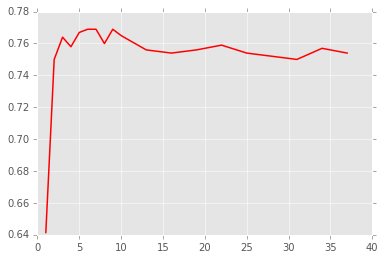

In [19]:
training = [(f[i], l[i]) for i in range(f.shape[0])]

x_points = [x for x in range(1,10)] + [x for x in range(10, 40, 3)]
y_points = []

for k in x_points:
    knn = KNN(k)
    correct = 0
    for i in training:
        if knn.predict(training, i[0]) == i[1][0]:
            correct += 1
    y_points.append(correct*1.0/len(training))
plt.plot(x_points, y_points, 'r-',lw=1.5)

### Conclusion

From the figures above, we find that both method have a peak accuracy rate of 77 near 6. Congratulations! Our simplest k-NN algorithm works very well on this data set compared with sklearn library. 

When k is small than 6, there is a wave due to the sensitivity of the noise. At the same time, we can infer that larger k gives smoother boundaries, better for generalization, but could have worse performance when boundaries become too blurry.

## Improved K-NN

As we discussed before, assign a weight to each feature is a way to improve K-NN. In original K-NN, we assign a class label based on the majority of each feature in the range of k neighbors. Now we multiply the value of each feature with a weight. The weight comes from inverse distance and the distance is the mean distance test point and all points of that feature.

The following method is one way we implement the idea above. We can insert into our K-NN implementation to see the difference.

In [10]:
def majority_vote2(neighbors):

    """
    neighbors[0] like: ([[1,2,3,4], ['MISC']], dist)
    list of (label, weight), weight = # of same label * 1.0 / (avg dist / # of same )
    of them
    """
    AIM_label_cnt = 0
    AIM_label_total_dist = 0
    OWNX_label_cnt = 0
    OWNX_label_total_dist = 0
    BASIS_label_cnt = 0
    BASIS_label_total_dist = 0
    MISC_label_cnt = 0
    MISC_label_total_dist = 0
    CONT_label_cnt = 0
    CONT_label_total_dist = 0

    for row in neighbors:
        label, dist = row[0][1][0], row[1]
        if label == "AIM":
            AIM_label_cnt += 1
            AIM_label_total_dist += dist
        elif label == "OWNX":
            OWNX_label_cnt += 1
            OWNX_label_total_dist += dist
        elif label == "BASIS":
            BASIS_label_cnt += 1
            BASIS_label_total_dist += dist
        elif label == "MISC":
            MISC_label_cnt += 1
            MISC_label_total_dist += dist
        elif label == "CONT":
            CONT_label_cnt += 1
            CONT_label_total_dist += dist

    if AIM_label_total_dist == 0:
        AIM_label_total_dist = float('inf')
    if OWNX_label_total_dist == 0:
        OWNX_label_total_dist = float('inf')
    if BASIS_label_total_dist == 0:
        BASIS_label_total_dist = float('inf')
    if MISC_label_total_dist == 0:
        MISC_label_total_dist = float('inf')
    if CONT_label_total_dist == 0:
        CONT_label_total_dist = float('inf')

    label_list = [("AIM", AIM_label_cnt**2*1.0/AIM_label_total_dist),
                  ("OWNX", OWNX_label_cnt**2*1.0/OWNX_label_total_dist),
                  ("BASIS", BASIS_label_cnt**2*1.0/BASIS_label_total_dist),
                  ("MISC", MISC_label_cnt**2*1.0/MISC_label_total_dist),
                  ("CONT", CONT_label_cnt**2*1.0/CONT_label_total_dist)]
    label_list.sort(key = lambda x: x[1], reverse=True)
    return label_list[0][0]

## Reference

- [Wiki for K-NN](https://www.wikiwand.com/en/K-nearest_neighbors_algorithm)
- [Weighted K-NN](http://www.csee.umbc.edu/~tinoosh/cmpe650/slides/K_Nearest_Neighbor_Algorithm.pdf)
- [Attribute weighting in K-nearest neighbor classification](https://tampub.uta.fi/bitstream/handle/10024/96376/GRADU-1417607625.pdf?sequence=1)
- [From Cambridge KNN](https://blog.cambridgecoding.com/2016/01/16/machine-learning-under-the-hood-writing-your-own-k-nearest-neighbour-algorithm/)
